## PINN eikonal solver for a portion of the Marmousi model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel, PDE
from sciann.utils import *
import scipy.io 
import time
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In [2]:
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
# Loading velocity model

filename="./Data/marm/model/marm_vz.txt"
marm = pd.read_csv(filename, index_col=None, header=None)
velmodel = np.reshape(np.array(marm), (101, 101)).T

# Loading reference solution

filename="./Data/marm/traveltimes/fmm_or2_marm_s(1,1).txt"
T_data = pd.read_csv(filename, index_col=None, header=None)
T_data = np.reshape(np.array(T_data), (101, 101)).T

In [4]:
#Model specifications

zmin = 0.; zmax = 2.; deltaz = 0.02;
xmin = 0.; xmax = 2.; deltax = 0.02;


# Point-source location
sz = 1.0; sx = 1.0;

# Number of training points
num_tr_pts = 3000

In [5]:
# Creating grid, calculating refrence traveltimes, and prepare list of grid points for training (X_star)

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size


Z,X = np.meshgrid(z,x,indexing='ij')

X_star = [Z.reshape(-1,1), X.reshape(-1,1)]

selected_pts = np.random.choice(np.arange(Z.size),num_tr_pts,replace=False)
Zf = Z.reshape(-1,1)[selected_pts]
Zf = np.append(Zf,sz)
Xf = X.reshape(-1,1)[selected_pts]
Xf = np.append(Xf,sx)


X_starf = [Zf.reshape(-1,1), Xf.reshape(-1,1)]

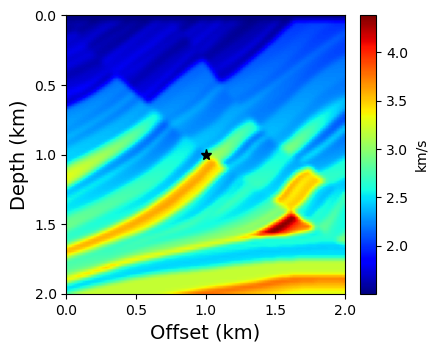

In [6]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.show()

In [7]:
# Analytical solution for the known traveltime part
vel = velmodel[int(round(sz/deltaz)),int(round(sx/deltax))] # Velocity at the source location

T0 = np.sqrt((Z-sz)**2 + (X-sx)**2)/vel; 

px0 = np.divide(X-sx, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-sz, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)

# Find source location id in X_star

TOLX = 1e-6
TOLZ = 1e-6

sids,_ = np.where(np.logical_and(np.abs(X_starf[0]-sz)<TOLZ , np.abs(X_starf[1]-sx)<TOLX))

print(sids)
print(sids.shape)
print(X_starf[0][sids,0])
print(X_starf[1][sids,0])

[3000]
(1,)
[1.]
[1.]


In [8]:
# Preparing the Sciann model object

K.clear_session() 

layers = [20]*10

# Appending source values
velmodelf = velmodel.reshape(-1,1)[selected_pts]; velmodelf = np.append(velmodelf,vel)
px0f = px0.reshape(-1,1)[selected_pts]; px0f = np.append(px0f,0.)
pz0f = pz0.reshape(-1,1)[selected_pts]; pz0f = np.append(pz0f,0.)
T0f = T0.reshape(-1,1)[selected_pts]; T0f = np.append(T0f,0.)

xt = Variable("xt",dtype='float64')
zt = Variable("zt",dtype='float64')
vt = Variable("vt",dtype='float64')
px0t = Variable("px0t",dtype='float64')
pz0t = Variable("pz0t",dtype='float64')
T0t = Variable("T0t",dtype='float64')

tau = Functional("tau", [zt, xt], layers, 'l-atan')

# Loss function based on the factored isotropic eikonal equation
L = (T0t*diff(tau, xt) + tau*px0t)**2 + (T0t*diff(tau, zt) + tau*pz0t)**2 - 1.0/vt**2

targets = [tau, 20*L, (1-sign(tau*T0t))*abs(tau*T0t)]
target_vals = [(sids, np.ones(sids.shape).reshape(-1,1)), 'zeros', 'zeros']

model = SciModel(
    [zt, xt, vt, pz0t, px0t, T0t], 
    targets,
#     load_weights_from='models/vofz_model-end.hdf5',
    optimizer='scipy-l-BFGS-B'
)

In [9]:
#Model training

start_time = time.time()
hist = model.train(
       X_starf + [velmodelf,pz0f,px0f,T0f],
       target_vals,
       batch_size = X_starf[0].size,
       epochs = 12000,
       learning_rate = 0.008,
       verbose=0
       )
elapsed = time.time() - start_time
print('Training time: %.2f seconds' %(elapsed))


Total samples: 3001 
Batch size: 3001 
Total batches: 1 

Training time: 918.15 seconds


In [10]:
# Convergence history plot for verification

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
#ax.semilogy(np.arange(0,300,0.001),hist.history['loss'],LineWidth=2)
ax.semilogy(hist.history['loss'],LineWidth=2)

ax.set_xlabel('Epochs (x $10^3$)',fontsize=16)

plt.xticks(fontsize=12)
#ax.xaxis.set_major_locator(plt.MultipleLocator(50))

ax.set_ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12);
plt.grid()

C:\Users\51158\.conda\envs\sciNNproject\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


In [12]:
# Predicting traveltime solution from the trained model

L_pred = L.eval(model, X_star + [velmodel.flatten(),pz0.flatten(),px0.flatten(),T0.flatten()])
tau_pred = tau.eval(model, X_star + [velmodel.flatten(),pz0.flatten(),px0.flatten(),T0.flatten()])
tau_pred = tau_pred.reshape(Z.shape)

T_pred = tau_pred*T0

print('Time at source: %.4f'%(tau_pred[int(round(sz/deltaz)),int(round(sx/deltax))]))

Time at source: 1.0000


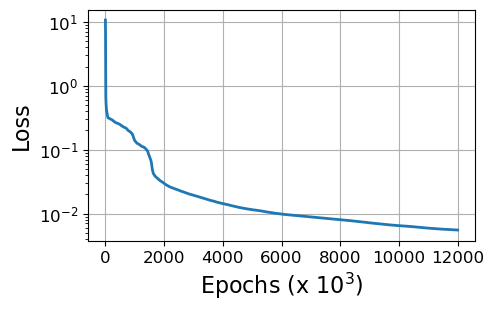

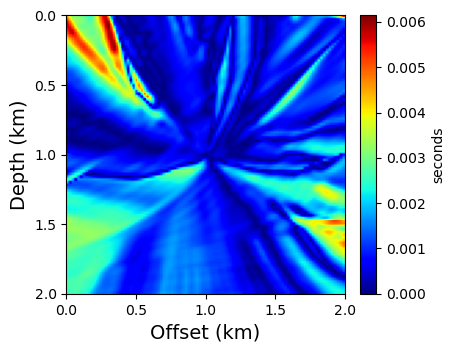

In [13]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_pred-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)
cbar.ax.tick_params(labelsize=10)

plt.show()

In [14]:
# Load fast sweeping traveltims for comparison

T_fsm = np.load('./Data/marm/traveltimes/Tcomp.npy')

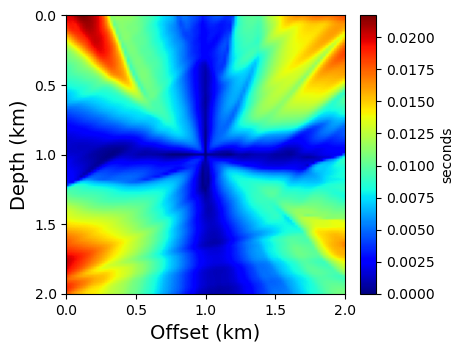

In [15]:
# Plot the first order FMM solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fsm-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)

cbar.ax.tick_params(labelsize=10)

plt.show()

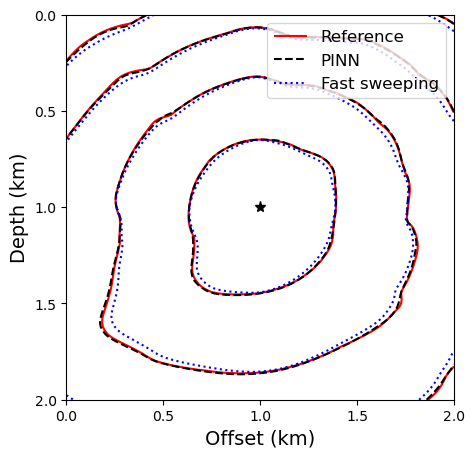

In [16]:
# Traveltime contour plots

fig = plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data, 6, extent=[xmin,xmax,zmin,zmax], colors='r')
im2 = ax.contour(T_pred, 6, extent=[xmin,xmax,zmin,zmax], colors='k',linestyles = 'dashed')
im3 = ax.contour(T_fsm, 6, extent=[xmin,xmax,zmin,zmax], colors='b',linestyles = 'dotted')

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Reference', 'PINN', 'Fast sweeping'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [17]:
print(np.linalg.norm(T_pred-T_data)/np.linalg.norm(T_data))
print(np.linalg.norm(T_pred-T_data))

0.004985816476050025
0.16482280006636127
